In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import shap

import time
import pickle as pkl
from scipy import stats

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import category_encoders as ce

# for classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score,multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# import our functions from our .py files
from model_preprocessing import *
from modelling import *

# Preprocessing of the data

In [3]:
# load and import the data
df_model = pd.read_csv('df_model.csv')

# set seed for reproducibility

set_seed()

df = drop_columns(df_model)
df = date_time_converting(df_model)
df = missing_values(df_model)
df = encoding(df_model)

# set ID_BUYER as index
df.set_index('ID_BUYER', inplace=True)

In [4]:
X = df.drop(['REPEATER', 'CLTV'], axis=1) 
y_REPEATER = df['REPEATER']
y_CLTV = df['CLTV']

# keeping colnames for later use
colnames = X.columns
# REPEATER
## split the data into train and test sets, apply target encoding for each model
X_train_REPEATER, X_test_REPEATER, y_train_REPEATER, y_test_REPEATER = train_test_split(X, y_REPEATER, test_size=0.2, random_state=42)

## Apply Target Encoding
X_train_REPEATER, X_test_REPEATER = target_encoding(X_train_REPEATER, X_test_REPEATER, target_col=y_train_REPEATER)

# CLTV
## split the data into train and test sets, apply target encoding for each model
X_train_CLTV, X_test_CLTV, y_train_CLTV, y_test_CLTV = train_test_split(X, y_CLTV, test_size=0.2, random_state=42)

## Apply Target Encoding
X_train_CLTV, X_test_CLTV = target_encoding(X_train_CLTV, X_test_CLTV, target_col=y_train_CLTV)

# Model 1 : Predicting the probability of a customer to be a Repeater

In [5]:
X_train_REPEATER_scaled, X_test_REPEATER_scaled = scaling(df, X_train_REPEATER, X_test_REPEATER, scaling=True, scaler='MinMaxScaler')

Testing different classification models

Logistic Regression has been fitted and evaluated
It took 2.6102051734924316 seconds to fit and evaluate the model
--------------------------------------
KNN has been fitted and evaluated
It took 15.44167447090149 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 3.3404715061187744 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 12.048176288604736 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 89.12966775894165 seconds to fit and evaluate the model
--------------------------------------
HIstGradientBoosting has been fitted and evaluated
It took 7.366861343383789 seconds to fit and evaluate the model
--------------------------------------
XGBoost has been fitted and evaluated
It took 3.0598134994506836 seconds to fit and evaluate the model
-----

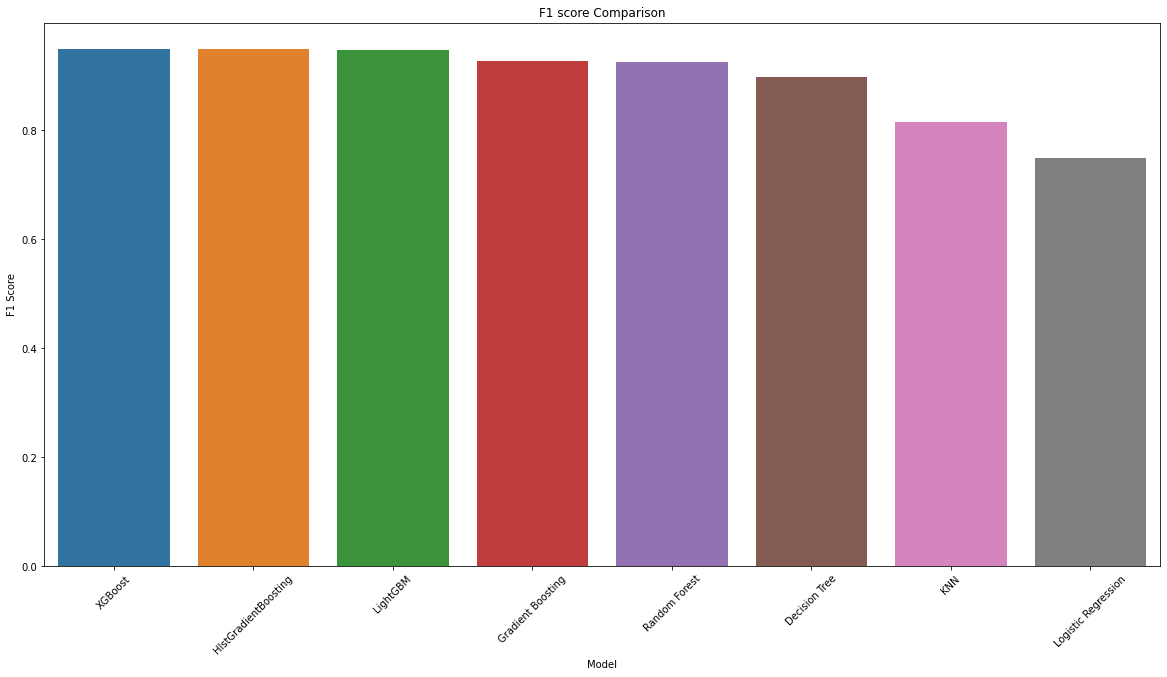

In [7]:
df_classification_result = classification_model_testing(df, X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER)

In [8]:
df_classification_result 

,Model,Accuracy,Precision,Recall,F1,Precision_Std,Recall_Std,F1_std
0,XGBoost,0.971702,0.978975,0.922598,0.949947,0.003392,0.003237,0.002735
1,HIstGradientBoosting,0.971226,0.979508,0.920387,0.949025,0.003437,0.005659,0.004524
2,LightGBM,0.969819,0.954709,0.940945,0.947775,0.004959,0.005394,0.005022
3,Gradient Boosting,0.959163,0.970848,0.886313,0.926655,0.004119,0.002964,0.003328
4,Random Forest,0.958042,0.961448,0.891637,0.925206,0.006008,0.005984,0.003993
5,Decision Tree,0.939662,0.891027,0.903186,0.897045,0.005874,0.007613,0.005217
6,KNN,0.899302,0.874504,0.763617,0.815295,0.006366,0.007487,0.006327
7,Logistic Regression,0.871767,0.869859,0.657875,0.749134,0.009284,0.008895,0.008189


We are focusing on the F1 Score Metric as we are in an unbalanced dataset. EXPLICATION
Also, we can see that we have our 3 Boosting models (XGBoost, HistGBM, LightGBM) that are performing better than the others.
We are going to focus on Light GBM as it has the highest recall score.
Why is recall score interesting for us ? EXPLICATION

## Hyperparameter Tuning

So we have chosen LightGBM.
Explication très simpliste light bgm 
Explication techinuqe

Explication BayesSearchCV tuning.
Explication des parametres tunés.

It took 224.00688433647156 seconds or 3.733448072274526 minutes to fit and evaluate the model
--------------------------------------
Best score:  0.942255911854503
Best params:  OrderedDict([('learning_rate', 0.09236611604062085)])
--------------------------------------
Accuracy score: 0.9607132640411938
Precision score: 0.9405278984296692
Recall score: 0.9232535257461463
F1 score: 0.9318106587222774
--------------------------------------
Confusion matrix: 
 [[7260  178]
 [ 234 2815]]
--------------------------------------
Classification report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      7438
         1.0       0.94      0.92      0.93      3049

    accuracy                           0.96     10487
   macro avg       0.95      0.95      0.95     10487
weighted avg       0.96      0.96      0.96     10487

--------------------------------------


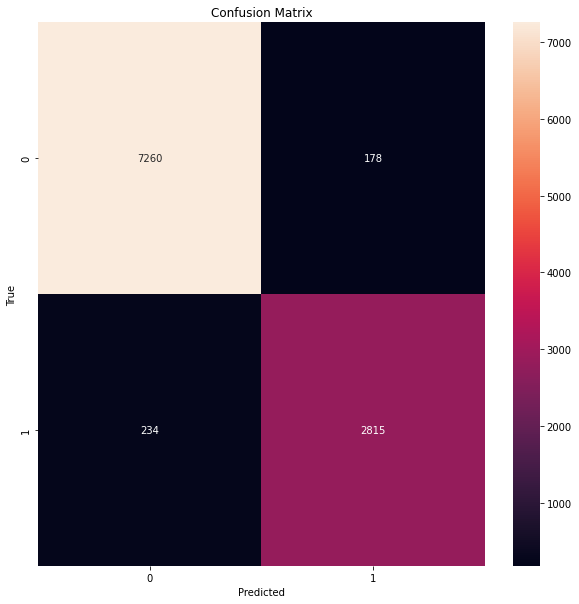

--------------------------------------


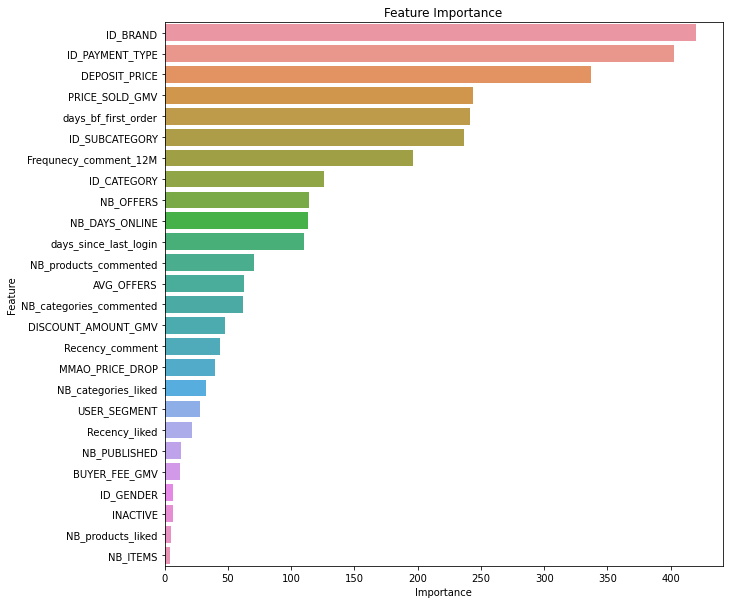

--------------------------------------


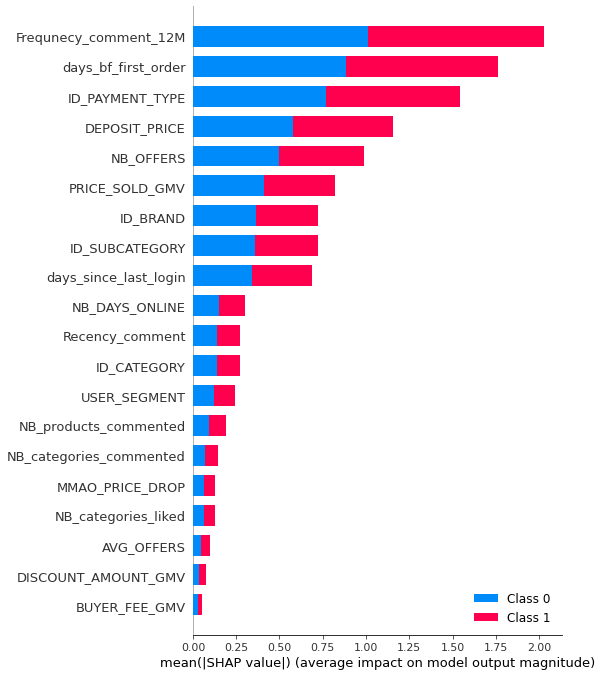

--------------------------------------


In [7]:
best_model_LGBM_class, df_classification_result, repeater_pred_proba = hyperparameter_tuning_lgbm_class(X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER, colnames)

## Weighted Model Output with Customer Present Value 



Now that we have our Repeater predictions, we can use this and create a composite score for each customer by taking the predicted probability for a customer to become a repeater and multiplying it by it current value. We will apply different weights for the two components, keeping it simple at the moment. 


In [9]:
repeater_pred_proba = pd.DataFrame(np.load('preds\REPEATER_LightGBM.npy'), columns=['REPEATER_pred_proba'])

X_test_REPEATER_scaled_df = pd.DataFrame(X_test_REPEATER_scaled, columns=colnames, index=X_test_REPEATER.index)
composite_df = calculate_composite_score(repeater_pred_proba, X_test_REPEATER_scaled_df, df_model, weight_repeater=0.8, weight_cv=0.2)

composite_df.head()

,ID_BUYER,REPEATER_pred_proba,CLTV,COMPOSITE_SCORE
0,15782933,0.970267,457269.017198,1.000000
1,15322244,0.922675,188348.477446,0.411888
2,13766936,0.980211,164650.364050,0.360063
3,16525824,0.999354,164362.040693,0.359432
4,15452164,0.998544,100293.025300,0.219317


# Model 2 : Adding the predicted Customer Lifetime Value (CLV) of a customer for our Composite Model

In [6]:
X_train_CLTV_scaled, X_test_CLTV_scaled = scaling(df, X_train_CLTV, X_test_CLTV, scaling=True, scaler='MinMaxScaler')

Linear Regression has been fitted and evaluated
It took 0.2607576847076416 seconds to fit and evaluate the model
--------------------------------------
Ridge Regression has been fitted and evaluated
It took 0.12515997886657715 seconds to fit and evaluate the model
--------------------------------------
Lasso Regression has been fitted and evaluated
It took 0.9953384399414062 seconds to fit and evaluate the model
--------------------------------------
ElasticNet Regression has been fitted and evaluated
It took 0.35804200172424316 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 6.02687406539917 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 74.62073707580566 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 73.71566677093506 seconds to fit and ev

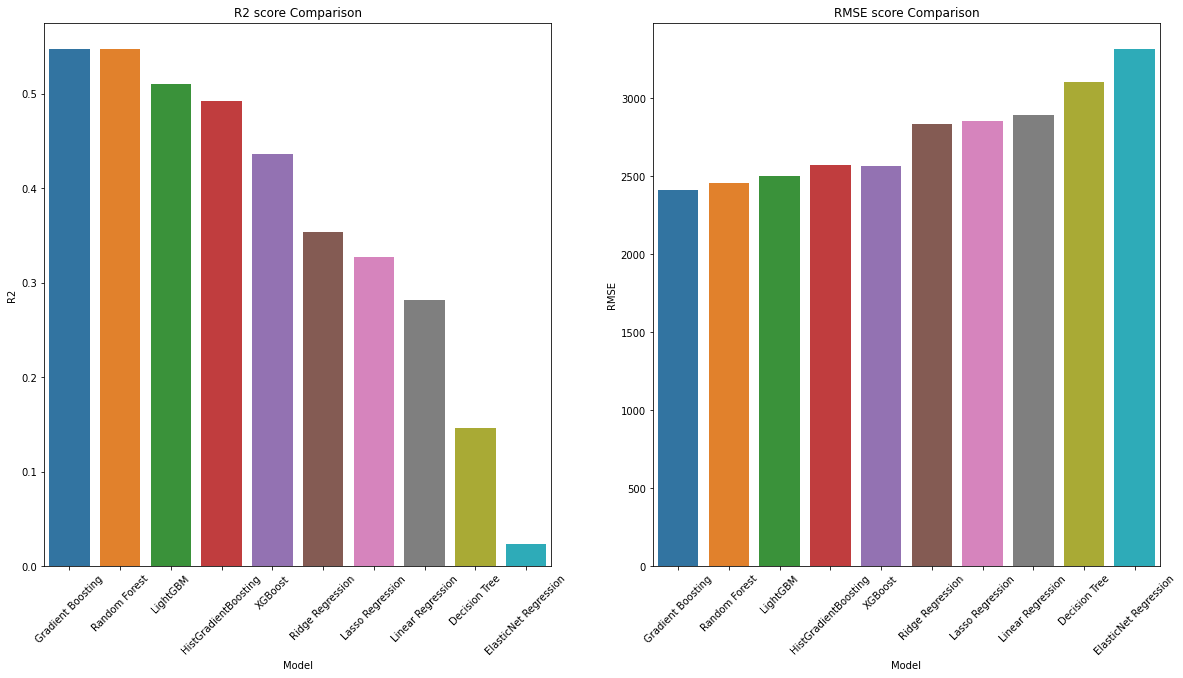

In [7]:
df_regression_result = regression_model_testing(df, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

In [8]:
df_regression_result

,Model,MAE,MSE,RMSE,R2
0,Gradient Boosting,397.523596,5.809361e+06,2410.261641,0.547845
1,Random Forest,355.173700,6.031010e+06,2455.811490,0.547247
2,LightGBM,375.776486,6.270551e+06,2504.106821,0.510393
3,HistGradientBoosting,395.154277,6.606049e+06,2570.223568,0.492047
4,XGBoost,386.391549,6.589346e+06,2566.972057,0.436135
5,Ridge Regression,605.799192,8.033074e+06,2834.267829,0.353364
6,Lasso Regression,588.309065,8.153003e+06,2855.346329,0.327057
7,Linear Regression,591.477193,8.375469e+06,2894.040189,0.281871
8,Decision Tree,470.179957,9.644952e+06,3105.632256,0.146590
9,ElasticNet Regression,853.708244,1.100722e+07,3317.713046,0.023336


CHOICE OF MODEL: 


## Hyperparameter Tuning

OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.49999999999999994), ('learning_rate', 0.01358647939816787), ('max_depth', 9), ('min_child_weight', 6), ('n_estimators', 455), ('reg_alpha', 1e-09), ('reg_lambda', 0.23524542592441905), ('subsample', 0.4367832531863225)])
0.511907650785472
It took 1761.587369441986 seconds to tune, fit and evaluate the model
---------
MSE = 27115898.824115094
RMSE = 5207.292849851551
MAE = 462.7277395648649
R2 = 0.25033231880143847
---------
Evaluation finie !
---------


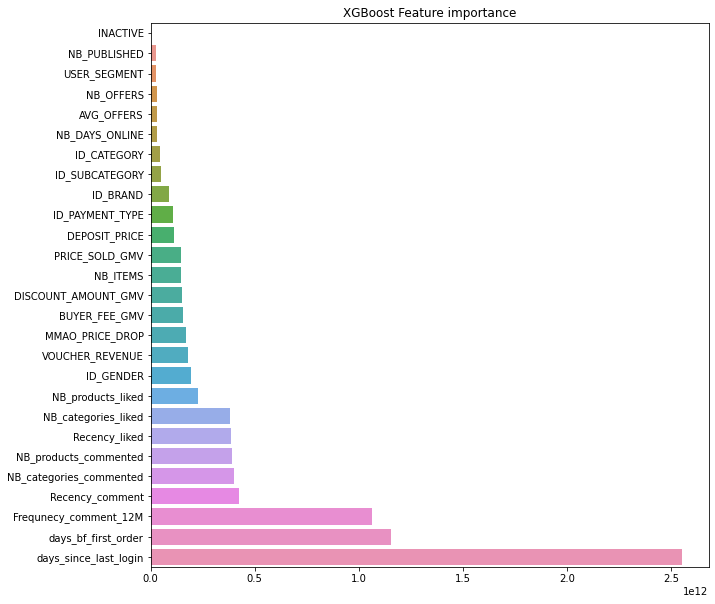

---------


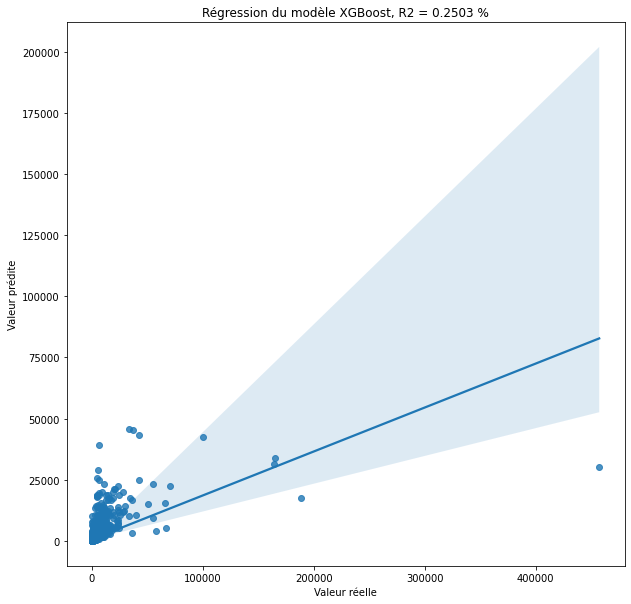

-------
Fin de l'évaluation du modèle XGBoost !


In [36]:
df_xgboost_tuned, model_test_xgb, cltv_pred_xgb = xgb_evaluation(df, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

Bayesian Search took 184.00836563110352 seconds
Best score:  -6536916.0241278345
Best params:  OrderedDict([('learning_rate', 0.03453769596301085)])
MSE score: 27751397.73390989
RMSE score: 5267.9595417874925
MAE score: 482.2509395243026
R2 score: 0.2327628110672384


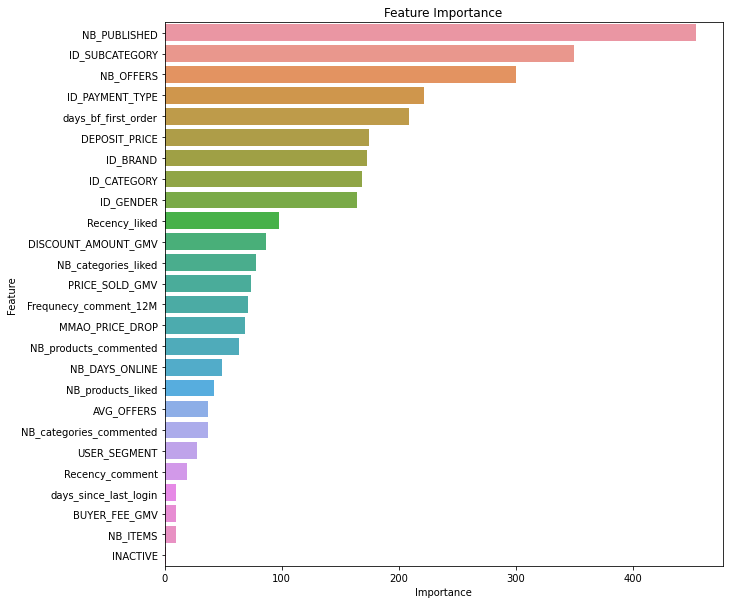

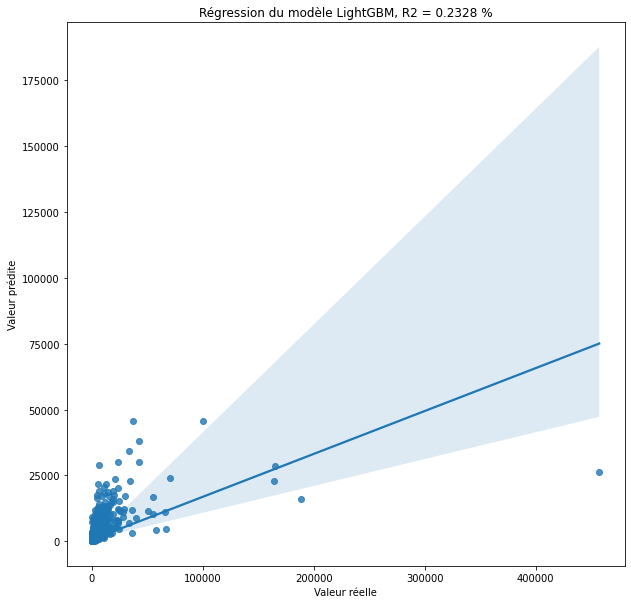

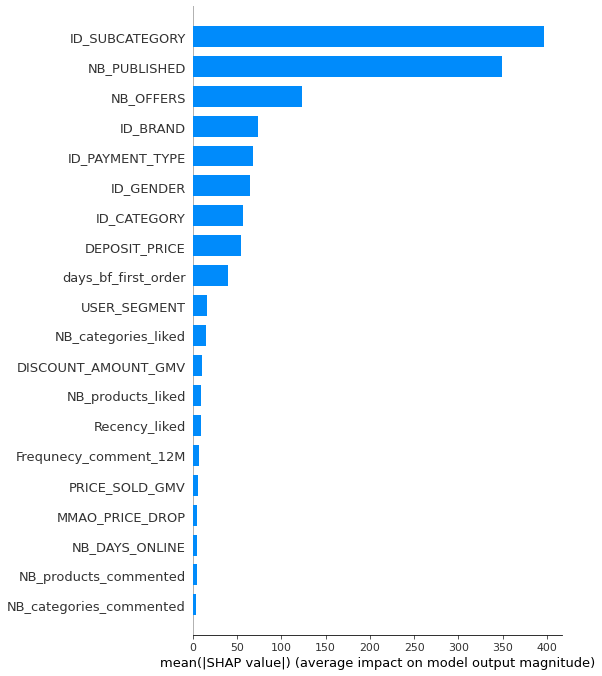

In [8]:
best_model_lgbm, cltv_pred_lgbm = hyperparameter_tuning_lgbm_reg(X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV, colnames)

### Scoring Model

In [22]:
# Use the predicted Repeater rate & the predicted CLTV  

repeater_pred_proba = np.load('preds\REPEATER_LightGBM.npy')

cltv_pred_lgbm = np.load('preds\CLTV_pred_lgbm.npy') 

WA_df = WA_Scoring(X_test_REPEATER, repeater_pred_proba, cltv_pred_lgbm, weight_repeater=0.2, weight_CLTV=0.8)

WA_df.head()

,repeater_pred_proba,cltv_pred_lgbm,Composite_Score
ID_BUYER,,,
15452164,0.998544,45797.923154,1.000000
13741897,0.076270,45758.010801,0.999121
15042553,0.998388,38170.703857,0.833058
10600848,0.982755,34133.108762,0.744685
13649565,0.997418,30280.299156,0.660356


# Uplift Model

In [17]:
# Add a treatment column to the dataframe
# Randomly assign a 0 or 1 to each row. 1 for treatment, 0 for control
df['treatment'] = np.random.randint(2, size=len(df))

In [18]:
df.treatment.value_counts()

0    26291
1    26143
Name: treatment, dtype: int64

In [19]:
# Let's check the treatment's correlation to repeat purchases:
def correlation_treatment(df:pd.DataFrame):
    """Function to calculate the treatment's correlation
    """
    correlation = df[['treatment','REPEATER']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['REPEATER'] * 100,2)))

correlation_treatment(df)

,REPEATER
treatment,1.04
REPEATER,100.00


In [20]:
def declare_target_class(df:pd.DataFrame):
    """Function for declare the target class
    """
    # Control Non Repeaters (CN) : 0
    df['target_class'] = 0 
    # Control Repeaters (CR) : 1
    df.loc[(df.treatment == 0) & (df.REPEATER == 0),'target_class'] = 1 
    # Treatment Non Repeaters (TN) : 2
    df.loc[(df.treatment == 1) & (df.REPEATER == 1),'target_class'] = 2 
    # Treatment Repeaters (TR) : 3
    df.loc[(df.treatment == 1) & (df.REPEATER == 0),'target_class'] = 3 
    return df

df = declare_target_class(df)

In [34]:
df.head()

,ID_GENDER,INACTIVE,NB_PUBLISHED,USER_SEGMENT,REPEATER,CLTV,NB_OFFERS,AVG_OFFERS,NB_DAYS_ONLINE,ID_CATEGORY,ID_SUBCATEGORY,ID_BRAND,ID_PAYMENT_TYPE,DEPOSIT_PRICE,PRICE_SOLD_GMV,NB_ITEMS,DISCOUNT_AMOUNT_GMV,BUYER_FEE_GMV,MMAO_PRICE_DROP,VOUCHER_REVENUE,NB_products_liked,NB_categories_liked,Recency_liked,NB_products_commented,NB_categories_commented,Recency_comment,Frequnecy_comment_12M,days_bf_first_order,days_since_last_login,treatment,target_class
ID_BUYER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15347487,2,0,1,10,1.0,4011.086544,55.0,1.447368,61,[13. 14. 63.],[ 54. 598.],14,65,505.853754,443.753592,1.0,12.464280,9.906643,18.370339,12.464280,185.0,5.0,9.0,2.0,1.0,204.0,406.0,163,33,0,0
17180639,2,0,1,4,0.0,684.884065,20.0,2.222222,198,[13. 14. 63.],[507. 598. 609.],[ 14 650 3119],65,247.010703,170.155022,3.0,7.751938,17.441860,39.033872,7.751938,44.0,5.0,68.0,0.0,0.0,999.0,0.0,20,63,1,3
13154196,1,0,0,5,0.0,239.520964,136.0,1.700000,469,13.0,84.0,[ 47 58 187],45,173.410970,79.840321,3.0,7.984032,0.000000,15.037268,7.984032,29.0,2.0,319.0,0.0,0.0,999.0,0.0,216,163,0,1
16618931,1,0,0,1,0.0,273.159145,0.0,0.000000,77,14.0,125.0,94,55,271.867612,273.159145,1.0,23.752969,0.000000,0.000000,23.752969,0.0,0.0,999.0,0.0,0.0,999.0,0.0,1,291,1,3
15612679,2,0,0,2,0.0,209.625000,0.0,0.000000,2,13.0,510.0,191,56,195.000000,209.625000,1.0,0.000000,17.730496,0.000000,0.000000,1.0,1.0,340.0,0.0,0.0,999.0,0.0,1,160,1,3


In [35]:
def split_data(df:pd.DataFrame):
    """Split data into training data and testing data
    """
    X = df.drop(['REPEATER', 'CLTV','target_class','ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE'],axis=1)
    y = df.REPEATER
    z = df.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def machine_learning(X_train:pd.DataFrame,
                     X_test:pd.DataFrame,
                     y_train:pd.DataFrame,
                     y_test:pd.DataFrame,
                     z_train:pd.DataFrame,
                     z_test:pd.DataFrame):
    """Machine learning process consists of 
    data training, and data testing process (i.e. prediction) with XGBoost (XGB) Algorithm
    """

    # prepare a new DataFrame
    prediction_results = pd.DataFrame(X_test).copy()
    
    
    # train the ETP model
    model_tp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # prediction Process for ETP model 
    prediction_tp \
    = model_tp.predict(X_test.drop('treatment',axis=1))
    probability__tp \
    = model_tp.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_REPEATER'] = prediction_tp
    prediction_results['proba_REPEATER'] = probability__tp[:,1]
    
    
    # train the ETU model
    model_etu \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # prediction Process for ETU model 
    prediction_etu \
    = model_etu.predict(X_test.drop('treatment', axis=1))
    probability__etu \
    = model_etu.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediction_target_class'] = prediction_etu
    prediction_results['proba_CN'] = probability__etu[:,0] 
    prediction_results['proba_CR'] = probability__etu[:,1] 
    prediction_results['proba_TN'] = probability__etu[:,2] 
    prediction_results['proba_TR'] = probability__etu[:,3]
    prediction_results['score_etu'] = prediction_results.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # add the REPEATER and target class into dataframe as validation data
    prediction_results['REPEATER'] = y_test
    prediction_results['target_class'] = z_test
    return prediction_results


def predict(df:pd.DataFrame):
    """Combining data split and machine learning process with XGB
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df)
    prediction_results = machine_learning(X_train,
                                          X_test,
                                          y_train,
                                          y_test,
                                          z_train,
                                          z_test)
    print("✔️Prediction succeeded")
    return prediction_results

# Machine Learning Modelling Process
print("Predicting dataset 1 ...")
prediction_results_1 = predict(df)

Predicting dataset 1 ...
✔️Prediction succeeded


### Evaluating predictive performance

In [36]:
def cm_evaluation(df:pd.DataFrame):
    """Confusion matrix evaluation
    """  
    print("===================================")
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df['REPEATER'], df['prediction_REPEATER'])
    df_confusion_etp = pd.DataFrame(confusion_etp, columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_confusion_etp)
    
    print("-----------------------------------")
    
    print("2. ETU's confusion matrix result:")   
    confusion_etu = multilabel_confusion_matrix(df['target_class'], df['prediction_target_class'])
    print("a. CN's confusion matrix:")  
    df_cn = pd.DataFrame(confusion_etu[0], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cn)
    print("b. CR's confusion matrix:") 
    df_cr = pd.DataFrame(confusion_etu[1], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_cr) 
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(confusion_etu[2], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tn) 
    print("d. TR's confusion matrix:") 
    df_tr = pd.DataFrame(confusion_etu[3], columns = ['Predicted True','Predicted False'], index = ['Actual True','Actual False'])
    print(df_tr)
    
    print("===================================")

In [37]:
# Confusion Matrix Evaluation
print("✔️Dataset 1")
cm_evaluation(prediction_results_1)

✔️Dataset 1
1. ETP's confusion matrix result:
              Predicted True  Predicted False
Actual True            13702             3692
Actual False            2498            12438
-----------------------------------
2. ETU's confusion matrix result:
a. CN's confusion matrix:
              Predicted True  Predicted False
Actual True            20040             4870
Actual False            4442             2978
b. CR's confusion matrix:
              Predicted True  Predicted False
Actual True            18863             4750
Actual False            5249             3468
c. TN's confusion matrix:
              Predicted True  Predicted False
Actual True            19804             5010
Actual False            4311             3205
d. TR's confusion matrix:
              Predicted True  Predicted False
Actual True            18963             4690
Actual False            5318             3359


In [38]:
def accuracy_evaluation(df:pd.DataFrame):
    """Accuracy evaluation
    """
    akurasi_cp = accuracy_score(df['REPEATER'],
                                df['prediction_REPEATER'])
    print('✔️ETP model accuracy: %.2f%%' % (akurasi_cp * 100.0))
    
    
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediction_target_class'])
    print('✔️ETU model accuracy: %.2f%%' % (akurasi_uplift * 100.0))

In [39]:
# Accuracy Evaluation Process.
print("Dataset 1")
accuracy_evaluation(prediction_results_1)

Dataset 1
✔️ETP model accuracy: 80.85%
✔️ETU model accuracy: 40.24%


### Evaluation of the prescriptive performance

In [40]:
def sorting_data(df:pd.DataFrame):
    """Function to sort data
    """
    # Set up new DataFrames for ETP model and ETU model
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    
    
    # Add quantiles
    df_c['n'] = df.proba_REPEATER.rank(pct=True, ascending=False)
    df_u['n'] = df.score_etu.rank(pct=True, ascending=False)
    df_c['score'] = df['proba_REPEATER']
    df_u['score'] = df['score_etu']
    
    
    # Ranking the data by deciles
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Calculate the C, T, CR, and TR
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    

    # Calculate & add the qini value into the Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    qini_coef= df['uplift'].sum(skipna = True) - df['random'].sum(skipna = True)

    # Print the Qini coefficient
    print('✔️Qini coefficient = {} {}'.format(round(qini_coef, 2), '%'))
    
    # Add q0 into the Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini

def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df_u['model'] = 'ETU'
    df_c['model'] = 'ETP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot the qini curve
    """
    print('\nPlotting the qini curve...')
    
    # Define the data that will be plotted
    order = ['ETU','ETP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    
    # Additional plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    print('✔️Successfully plot the qini curve')
    return ax

def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_c, df_u = sorting_data(prediction_results)
    print('ETP model (previous model):')
    qini_c = calculating_qini(df_c)
    print('\nETU model (our proposed model):')
    qini_u = calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini


ETP model (previous model):
✔️Qini coefficient = -1.34 %

ETU model (our proposed model):
✔️Qini coefficient = 24.8 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

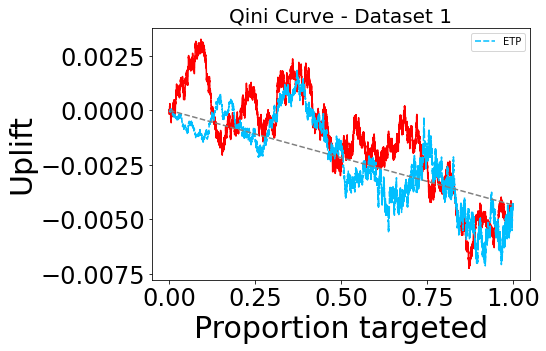

In [41]:
# Qini evaluation results for DataSet 1 with negative treatment correlation
ax, qini_1 = evaluation_qini(prediction_results_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)

✔️Treatment correlation in dataset 1 (inverted): -0.24
✔️Prediction succeeded
ETP model (previous model):
✔️Qini coefficient = 9.33 %

ETU model (our proposed model):
✔️Qini coefficient = 41.99 %

Plotting the qini curve...
✔️Successfully plot the qini curve


Text(0.5, 1.0, 'Qini Curve - Dataset 1')

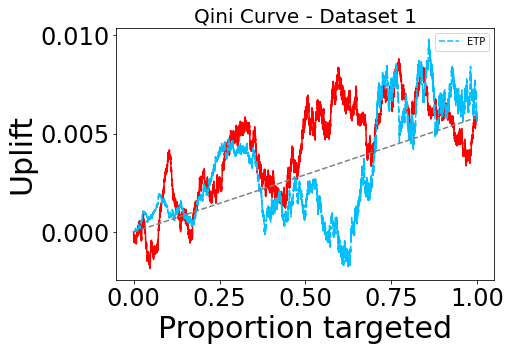

In [42]:
# The process to inverse treatment's parameter
# Thus also inverse the treatment's correlation from negative to positive
df.treatment = df.treatment.replace({0: 1, 1: 0})

# Recalculate the treatment correlation
print("✔️Treatment correlation in dataset 1 (inverted):", correlation_treatment(df).iloc[0,0])

# Add the target class feature to all three datasets
df_inverse = declare_target_class(df)

# Do the prediction process once more time
prediction_results_inverse_1 = predict(df_inverse)

# Qini evaluation results for DataSet 1 with positive treatment correlation
ax, qini_inverse_1 = evaluation_qini(prediction_results_inverse_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)

## Implementation of our solution

Test with people who had only one purchase